<h1>Анализ пользовательского поведения в мобильном приложении</h1>

<h2>Краткое описание проекта</h2>

Необходимо разобраться как ведут себя пользователи мобильного приложения онлайн-магазина продуктов питания.

<h2>Цель проекта</h2>

Необходимо проанализировать поведение покупателей на основании логов пользователей и результатов А/А/В - эксперимента (изменение шрифта во всем приложении).

<h2>План работы</h2>

* подготовка данных;
* изучение и проверка данных;
* изучение воронки событий;
* изучение результатов эксперимента;
* составление выодов.

<h3>Откроем датасет и изучим общую информацию</h3>

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats as st
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

Сформируем датасет

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Видим что столбец со временем события отображается в секундах. Тип данного столбца нуждается в преобразовании.

Посмотрим общую информацию

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Проверим имеются ли в датасете пропущенные значения

In [4]:
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Затем проверим на дубликаты

In [5]:
display(df.duplicated().sum())

413

Видим присутствие дубликатов. Необходимо от них избавиться.

<h3>Подготовим данные</h3>

In [6]:
df.duplicated().sum() / len(df)

0.0016917493425526163

Для начала удалим дубликаты

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

Затем переименуем столбцы приведя их к змеиному регистру

In [8]:
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 
                            'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

Добавим столбец даты и времени, а также отдельный столбец дат

In [9]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

Добавим отдельное поле с датой

In [10]:
df['date'] = pd.to_datetime(df['event_timestamp'].dt.date)

In [11]:
df

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Проверим имеются ли пересечения пользователей в группах. 

In [12]:
df.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1')

,device_id_hash,exp_id


Идентификаторов пользователей, участвующих в нескольких группах не обнаружено

<h3>Изучим и проверим данные</h3>

Узнаем сколько всего событий в логе

In [13]:
event_name = df['event_name'].count()
print('Всего в логе', event_name, 'событий.')

Всего в логе 243713 событий.


Узнаем сколько всего пользователей в логе

In [14]:
device_id_hash = df['device_id_hash'].nunique()
print('Количество пользователей в логе:', device_id_hash)

Количество пользователей в логе: 7551


In [15]:
events_by_user = df.groupby('device_id_hash').agg(event_count = ('event_name', 'count')).reset_index()
display(events_by_user['event_count'].describe())

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_count, dtype: float64

На пользователя в среднем приходится 32.275593 события

Выясним данными за какой период мы располагаем

In [16]:
print(f"Период данных: с {df['event_timestamp'].min()} по {df['event_timestamp'].max()}")
print(f"Размер периода : {df['event_timestamp'].max() - df['event_timestamp'].min()}")

Период данных: с 2019-07-25 04:43:36 по 2019-08-07 21:15:17
Размер периода : 13 days 16:31:41


Построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп.

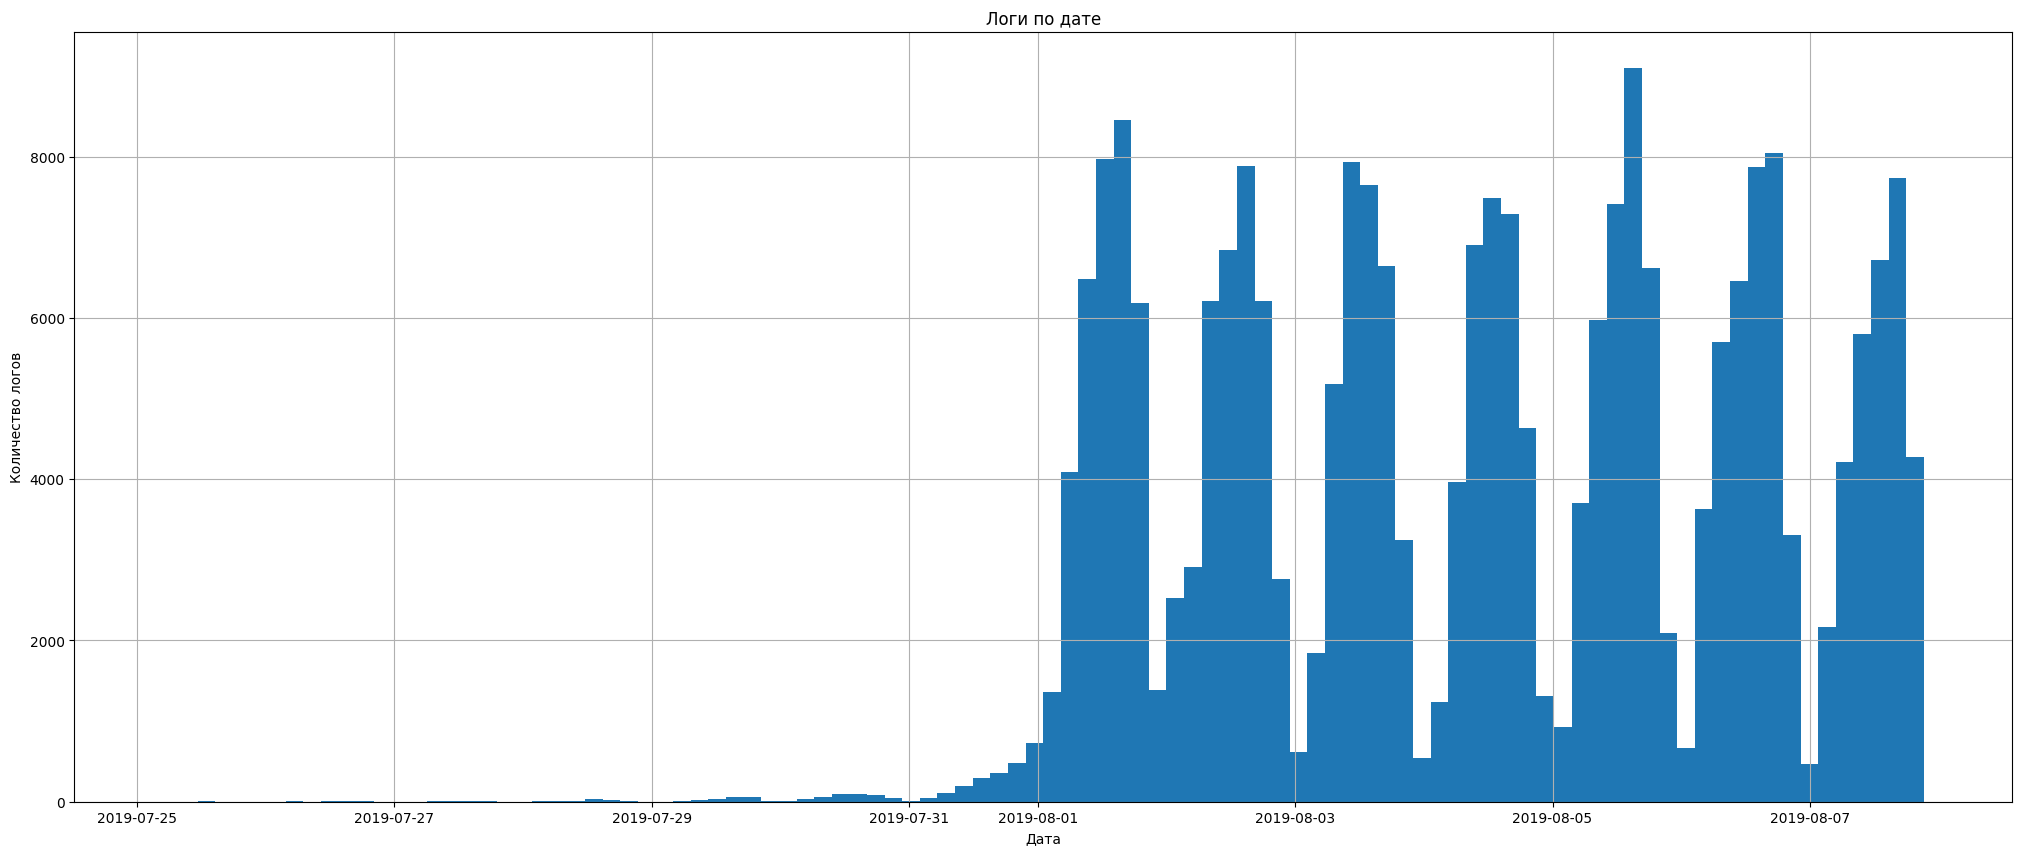

In [17]:
df['event_timestamp'].hist(bins=100,  figsize=(25, 10))
plt.title('Логи по дате')
plt.ylabel('Количество логов')
plt.xlabel('Дата')
plt.show()

Как видно из столбчатой диограммы, имеются полные данные начиная с 1 августа.
Данные до 1 августа удалим.

In [18]:
df_new = df.loc[df['date'] > '2019-07-31'].reset_index(drop=True)
df_new.sort_values(by='event_timestamp')

,event_name,device_id_hash,event_timestamp,exp_id,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
240883,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
240884,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
240885,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


После того как были отброшены некоторые события и пользователи узнаем много ли событий потеряно.

In [19]:
print(f"Количество потерянных собятий {len(df) - len(df_new)}")
print(f"Доля потерянных событий {(len(df) - len(df_new))/len(df):.1%}")

Количество потерянных собятий 2826
Доля потерянных событий 1.2%


Теперь узнаем много ли пользователей потеряно.

In [20]:
print(f"Количество потерянных пользователей {df['device_id_hash'].nunique()-df_new['device_id_hash'].nunique()}")
print(f"Доля потерянных пользователей {(df['device_id_hash'].nunique()-df_new['device_id_hash'].nunique())/df['device_id_hash'].nunique():.1%}")

Количество потерянных пользователей 17
Доля потерянных пользователей 0.2%


In [21]:
df_new.pivot_table(index = 'exp_id', values = 'device_id_hash', aggfunc = 'count')

,device_id_hash
exp_id,
246,79302
247,77022
248,84563


<h3>Изучим воронку событий</h3>

Посмотрим какие события есть в логах, как часто они встречаются. Затем отсортируем события по частоте.

In [22]:
df_new.groupby('event_name').agg(count = ('device_id_hash', 'count')).sort_values(by = 'count', ascending=False)

,count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Посчитаем сколько пользователей совершали каждое из этих событий. Затем отсортируем события по числу пользователей.

In [23]:
device_id_hash_event = df_new.groupby('event_name').agg(users=('device_id_hash','nunique')).sort_values('users', ascending=False)

In [24]:
device_id_hash_event

,users
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
device_id_hash_event['ratio'] = round(device_id_hash_event['users']/df_new['device_id_hash'].nunique() * 100, 2)

In [26]:
device_id_hash_event

,users,ratio
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Предположим в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 

Можно сделать вывод что на главной странице были 7419 пользователей что составляет почти 98,5%. К каталогу предложений перешли 4593 пользователя что составляет почти 61%. Карточки товаров изучали 3734 пользователя что составляет почти 50%. Оплатили товар 3539 пользователей что составляет почти 47%. Обучающее видео просмотрели 840 пользователей что составляет около 11%.
<br>Можно сделать вывод что первые четыре события выстраиваются в цепочку событий что нельзя сказать про пятое событие, которое резко проигрывает всем предыдущим. 
<br>Переход к обучающему видео можно исключить поскольку его просмотр не влияет на продажу продукта питания.
<br>Тем самым последовательность действий можно сформировать таким образом:
* MainScreenAppear
* OffersScreenAppear
* CartScreenAppear
* PaymentScreenSuccessful

Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Создадим сводную таблицу по названию событий и количеству пользователей, находящихся хотя бы раз на данном событии.

In [27]:
amount_users_to_events = df.query('event_name != "Tutorial"').pivot_table(index = 'event_name', values = 'device_id_hash', aggfunc = 'nunique').sort_values(by = 'device_id_hash', ascending = False)
amount_users_to_events

,device_id_hash
event_name,
MainScreenAppear,7439
OffersScreenAppear,4613
CartScreenAppear,3749
PaymentScreenSuccessful,3547


Создадим дополнительный столбец со значением конверсии на предыдущем шаге

In [28]:
amount_users_to_events['shift'] = amount_users_to_events['device_id_hash'].shift(1, fill_value = amount_users_to_events['device_id_hash'].loc[amount_users_to_events.index[0]])

Посчитаем отношение конверсии шага воронки продаж к конверсии предыдущего шага воронки продаж. Затем выведем отношение в процентном соотношении на экран.

In [29]:
amount_users_to_events['conversion'] = round(amount_users_to_events['device_id_hash']/amount_users_to_events['shift']*100, 1)

In [30]:
amount_users_to_events = amount_users_to_events[['device_id_hash', 'conversion']]

In [31]:
amount_users_to_events

,device_id_hash,conversion
event_name,,
MainScreenAppear,7439,100.0
OffersScreenAppear,4613,62.0
CartScreenAppear,3749,81.3
PaymentScreenSuccessful,3547,94.6


Можно сделать вывод что большинство пользователей теряется после первого этапа воронки.

Теперь выясним какая доля пользователей доходит от первого события до оплаты.

In [32]:
print(f"Доля пользователей от первого события до оплаты составляет {amount_users_to_events['device_id_hash'].loc[amount_users_to_events.index[-1]]/amount_users_to_events['device_id_hash'].loc[amount_users_to_events.index[0]]:.1%}")

Доля пользователей от первого события до оплаты составляет 47.7%


Мы видим, что наибольшее количество пользователей теряется после первого шага, а именно 38%. И только 47.7% от первоначального количества пользователей успешно оплачивают товары из корзины.

<h3>Изучим результаты эксперимента</h3>

Посчитаем сколько пользователей в каждой экспериментальной группе

In [33]:
df_new2 = df_new.groupby('exp_id', as_index=False).agg(count=('device_id_hash', 'nunique'))
df_new2

,exp_id,count
0,246,2484
1,247,2513
2,248,2537


Мы видим небольшую разницу в количестве пользователей в каждой экспериментальной группе

Необходимо убедиться в корректности самой разбивки на группы. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Еще раз найдём число пользователей в 246 и 247 группах

In [34]:
group_246 = (df_new[df_new['exp_id'] == 246]['device_id_hash']).nunique()
group_247 = (df_new[df_new['exp_id'] == 247]['device_id_hash']).nunique()

Рассчитаем на сколько процентов отличается количество пользователей в группах

In [35]:
print('Количество пользователей в группах различается на', round(100 - (group_246 / group_247 * 100), 2), '%')

Количество пользователей в группах различается на 1.15 %


Группы отличаются по количеству более, чем на 1%.

Выберим самое популярное событие.

In [36]:
df_test = df_new.pivot_table(index='event_name', columns='exp_id', values='device_id_hash',aggfunc='nunique').sort_values(by=246, ascending=False).reset_index()

In [37]:
df_test.rename(columns={246 : 'A', 247 : 'A1', 248 : 'B'}, inplace=True)

In [38]:
df_test

exp_id,event_name,A,A1,B
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Видим что самое популярное событие во всех группах это переход на главную страницу. Теперь посчитаем число пользователей и долю пользователей, совершивших это событие в каждой из контрольных групп.

In [39]:
df_test['share_246'] = (df_test['A'] / df_new2.loc[0,'count'] * 100).round(1)
df_test['share_247'] = (df_test['A1'] / df_new2.loc[1,'count'] * 100).round(1)
df_test['share_248'] = (df_test['B'] / df_new2.loc[2,'count'] * 100).round(1)

In [40]:
df_test

exp_id,event_name,A,A1,B,share_246,share_247,share_248
0,MainScreenAppear,2450,2476,2493,98.6,98.5,98.3
1,OffersScreenAppear,1542,1520,1531,62.1,60.5,60.3
2,CartScreenAppear,1266,1238,1230,51.0,49.3,48.5
3,PaymentScreenSuccessful,1200,1158,1181,48.3,46.1,46.6
4,Tutorial,278,283,279,11.2,11.3,11.0


Проверим будет ли отличие между группами статистически достоверным. Сформулируем гипотезы.

<b>H0:Между долями статистической значимой разницы нет, поведение групп не отличается;
<b><br>H1:Между долями статистическая значимая разница есть, поведение групп отличается.

In [41]:
group_246 = df_new.query('exp_id == 246')
group_247 = df_new.query('exp_id == 247')

In [42]:
def test(g1, g2, event_name, alpha, m):

#критический уровень статистической значимости с поправкой методом Шидака
    sidak_alpha = 1-pow(1-alpha,1/m)
    
#количество уникальных пользователей совершивших событие в каждой группе 
    un_users_event = np.array([g1[g1['event_name'] == event_name]['device_id_hash'].nunique(), 
                           g2[g2['event_name'] == event_name]['device_id_hash'].nunique()])
        
#количество уникальных пользователей в группах
    un_users_group = np.array([g1['device_id_hash'].nunique(), g2['device_id_hash'].nunique()])
    
# пропорция успехов в первой группе:
    p1 = un_users_event[0]/un_users_group[0]
# пропорция успехов во второй группе:
    p2 = un_users_event[1]/un_users_group[1]
    
# пропорция успехов в комбинированном датасете:
    p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
# разница пропорций в датасетах
    difference = p1 - p2
    
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/un_users_event[0] + 1/un_users_event[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
#Так как распределение статистики нормальное, вызовем метод cdf()
#Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
#Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
          
    print('p-значение: ', p_value)

    if p_value < sidak_alpha:
        print('Нулевая гипотеза отвергается: разница между группами по событию', event_name, 'статистически достоверна')
    else:
        print('Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию', event_name, 'статистически недостоверной')

Создадим список с уникальными событиями

In [43]:
event_name_array = df['event_name'].unique()

In [44]:
for event_name in event_name_array:
    test(group_246, group_247, event_name,.05, 4)

p-значение:  0.758737151572354
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию MainScreenAppear статистически недостоверной
p-значение:  0.2784401253423807
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию PaymentScreenSuccessful статистически недостоверной
p-значение:  0.39432110136773835
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию CartScreenAppear статистически недостоверной
p-значение:  0.36593695068605325
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию OffersScreenAppear статистически недостоверной
p-значение:  0.9791070433857165
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию Tutorial статистически недостоверной


Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.

Сделаем срез по группе тестирования мобильного приложения с изменённым шрифтом.

In [45]:
group_248 = df_new.query('exp_id == 248')

Всего у нас 4 вида событий, 4 A/A теста и 12 А/В, следовательно для всех тестов мы вводим поправку Бонферрони

Сравним контрольные группы 246 и 248

In [46]:
for event_name in event_name_array:
    test(group_246, group_248, event_name,.05, 12)

p-значение:  0.2987450335656847
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию MainScreenAppear статистически недостоверной
p-значение:  0.3903369220965023
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию PaymentScreenSuccessful статистически недостоверной
p-значение:  0.21469452387393084
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию CartScreenAppear статистически недостоверной
p-значение:  0.32498018019986397
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию OffersScreenAppear статистически недостоверной
p-значение:  0.941774193649735
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию Tutorial статистически недостоверной


Делаем вывод что значимой разницы в поведении пользователей групп 246 и 248 не обнаружено.

Теперь сравним контрольные группы 247 и 248

In [47]:
for event_name in event_name_array:
    test(group_247, group_248, event_name,.05, 12)

p-значение:  0.4623286535354567
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию MainScreenAppear статистически недостоверной
p-значение:  0.8194623261229845
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию PaymentScreenSuccessful статистически недостоверной
p-значение:  0.6978142226496611
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию CartScreenAppear статистически недостоверной
p-значение:  0.9376062948315385
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию OffersScreenAppear статистически недостоверной
p-значение:  0.9206806646801962
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию Tutorial статистически недостоверной


Делаем вывод что значимой разницы в поведении пользователей групп 247 и 248 не обнаружено.

Теперь сравним объединённую контрольную группу с группой тестирования мобильного приложения с измёнённым шрифтом

In [48]:
for event_name in event_name_array:
    test(pd.concat([group_246, group_247]), group_248, event_name,.05, 12)

p-значение:  0.2982116211407275
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию MainScreenAppear статистически недостоверной
p-значение:  0.7202057779473505
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию PaymentScreenSuccessful статистически недостоверной
p-значение:  0.34982490083868933
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию CartScreenAppear статистически недостоверной
p-значение:  0.5425331263544062
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию OffersScreenAppear статистически недостоверной
p-значение:  0.9207162647272609
Нулевую гипотеза не отвергается, нет оснований считать разницу между группами по событию Tutorial статистически недостоверной


Делаем вывод что значимой разницы в поведении пользователей объединённой контрольной группы и группы 248 не обнаружено.

Делаем вывод что изменение шрифтов во всём мобильном приложении на поведение пользователей не повлияло.

<h2>Выводы</h2>

Был взят критический уровень статистической значимости 0.05, что озачает что существует вероятность получить ошибку первого рода в одном из 20 случаев. 
<br>Было проведено 20 экспериментов. Если бы был взят уровень статистической значимости 0.1, вероятность увидеть ложноположительный результат была бы выше в 2 раза.

Стояла задача провести анализ влияния изменения шрифта в мобильном приложении на поведение пользователей.

Изначально в логе было 243713 событий и 7551 пользователей. Период данных был определён с 2019-07-25 по 2019-08-07. 
<br>Однако только начиная с 1 августа данные можно считать полными. В следствие этого часть данных за первую неделю была удалена. После удаления данные о пользователях присутствуют во всех трёх экспериментальных группах. В каждой примерно по 2500 пользователей.

Анализ воронки продаж показалчто из 7439 пользователей, переходящих на стартовую страницу, до оплаты дошли 3542, что составляет 47.7%. Можно признать это хорошим показателем, особенно если учесть, что 38% пользователей покидают мобильное приложение сразу после первого этапа.

Событие "Tutorial" не имеет влияние на заказы, оно исключено из отслеживания этого шага в дальнейшем.

Замечено что на шаге OffersScreenAppear (экран с товаром) теряется больше всего пользователей - 38%. Очевидно что отделу маркетинга/web-аналитикам необходимо принять меры чтобы уменьшить отток пользователей на данном шаге.

Статистически значимой разницы между группами во всех тестах по всем собятиям не выявлено. Можно сделать вывод что изменение шрифта не повлияло ни на один этап воронки продаж. Опасения менеджеров не подтвердились. Изменения шрифтов можно смело утвердить.